<a href="https://colab.research.google.com/github/bnsreenu/python_for_microscopists/blob/master/331_fine_tune_SAM_mito.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**This notebook walks you through the process of fine-tuning a Segment Anything Model (SAM) using custom data**.
<p>

**What is SAM?**
<br>
SAM is an image segmentation model developed by Meta AI. It was trained over 11 billion segmentation masks from millions of images. It is designed to take human prompts, in the form of points, bounding boxes or even a text prompt describing what should be segmented.
<p>

**What are the key features of SAM?**
<br>

* **Zero-shot generalization:** SAM can be used to segment objects that it has never seen before, without the need for additional training.

* **Flexible prompting:** SAM can be prompted with a variety of input, including points, boxes, and text descriptions.

* **Real-time mask computation:** SAM can generate masks for objects in real time. This makes SAM ideal for applications where it is necessary to segment objects quickly, such as autonomous driving and robotics.

* **Ambiguity awareness:** SAM is aware of the ambiguity of objects in images. This means that SAM can generate masks for objects even when they are partially occluded or overlapping with other objects.

<p>

**How does SAM work?**
<br>
SAM works by first encoding the image into a high-dimensional vector representation. The prompt is encoded into a separate vector representation. The two vector representations are then combined and passed to a mask decoder, which outputs a mask for the object specified by the prompt.
<p>
The image encoder is a vision transformer (ViT-H) model, which is a large language model that has been pre-trained on a massive dataset of images. The prompt encoder is a simple text encoder that converts the input prompt into a vector representation. The mask decoder is a lightweight transformer model that predicts the object mask from the image and prompt embeddings.
<p>

**SAM paper:** https://arxiv.org/pdf/2304.02643.pdf​
<p>




In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Install the required libraries
#SAM
!pip install git+https://github.com/facebookresearch/segment-anything.git
#Transformers
!pip install -q git+https://github.com/huggingface/transformers.git
#Datasets to prepare data and monai if you want to use special loss functions
!pip install datasets
!pip install -q monai
#Patchify to divide large images into smaller patches for training. (Not necessary for smaller images)
!pip install patchify

  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-v48t1x8r
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-v48t1x8r
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
  Created wheel for segment-anything: filename=segment_anything-1.0-py3-none-any.whl size=36590 sha256=99cdbfaaa18e49d8f524d1d4792da65b2235329381ebc85c2322d9557c7a49b0
  Stored in directory: /tmp/pip-ephem-wheel-cache-bvqjezr9/wheels/10/cf/59/9ccb2f0a1bcc81d4fbd0e501680b5d088d690c6cfbc02dc99d
Successfully built segment-anything
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tifffile
import os
# from patchify import patchify  #Only to handle large images
import random
from scipy import ndimage

In [ ]:
# lib imports
import torch
import os
import numpy as np
import pandas as pd
import random
import cv2

from tqdm import tqdm

from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt

In [ ]:
IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 3
IMG_COUNT = 480

In [ ]:
# set this between [1, 10] for differently composed datasets
# reference: https://arxiv.org/pdf/2307.05911.pdf
TRAINING_SET = 1

In [ ]:
# # extract data from zip file
# import zipfile
# import os

# # Define the path to your zip file and the directory where you want to extract it
# zip_file_path = '/content/drive/MyDrive/465 Project/archive.zip'
# extract_folder_path = '/content/drive/MyDrive/465 Project/Dataset'

# os.makedirs(extract_folder_path, exist_ok=True)

# with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
#     zip_ref.extractall(extract_folder_path)

In [ ]:
images = []
masks = []

target_size = (IMG_WIDTH, IMG_HEIGHT)
# 100% Manually Segmented
print("Selected Training Set 1")
print("Manually Segmented - 100% (480)")

image_dir = '/content/drive/MyDrive/465 Project/ArtificialDataset/GRAIN DATA SET/RG'
mask_dir = '/content/drive/MyDrive/465 Project/ArtificialDataset/GRAIN DATA SET/RGMask'

cnt = 0;
for file in sorted(os.listdir(image_dir)):
    if cnt == 120:
      break
    # Load the image and resize to the target size
    img = cv2.imread(os.path.join(image_dir, file))
    img = cv2.resize(img, target_size)
    cnt+=1

    # Append the resized image to the list of images
    images.append(img)
cnt = 0
for file in sorted(os.listdir(mask_dir)):
    if cnt == 120:
      break
    # Load the corresponding mask and resize to the target size
    mask = cv2.imread(os.path.join(mask_dir, file))
    mask = cv2.resize(mask, target_size)

    # Append the resized mask to the list of masks
    masks.append(mask)
    cnt+=1


IMG_COUNT = len(images)
print(f"image count : {IMG_COUNT}")

Selected Training Set 1
Manually Segmented - 100% (480)
image count : 120


In [ ]:
images = np.array(images)
masks = np.array(masks)
print(images.shape, masks.shape)
# change the Y to a boolean
masks = np.where(masks > 245, True, False)

(120, 256, 256, 3) (120, 256, 256, 3)


In [ ]:
# careful to run this cell only once (otherwise shape changes)
images = np.transpose(images, (0, 3, 1 , 2))
masks = np.transpose(masks, (0, 3, 1 , 2))
print(images.shape, masks.shape)

(120, 3, 256, 256) (120, 3, 256, 256)


In [ ]:
#convert the boolean where it insion s true (any of the 3 channels) to a (336, 128, 128, 1)
#basically reduce the 3 channel dimeRGB to just one boolean value

masks= np.any(masks, axis=1)
print(masks.shape)
masks = masks.reshape(IMG_COUNT, 1, IMG_HEIGHT, IMG_WIDTH)
print(masks.shape)


(120, 256, 256)
(120, 1, 256, 256)


In [ ]:
from torch.utils.data import Dataset

class GrainDataset(Dataset):
    def __init__(self, images, masks):
        self.images = images
        self.masks = masks

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = torch.from_numpy(self.images[idx]).float()
        mask = torch.from_numpy(self.masks[idx]).float()
        return image, mask

# Create the dataset
dataset = GrainDataset(images, masks)

In [ ]:
dataset, len(dataset)

(<__main__.GrainDataset at 0x7d3e34c72c20>, 120)

Let us make sure out images and masks (labels) are loading appropriately

torch.Size([256, 256, 3]) torch.Size([256, 256, 1])


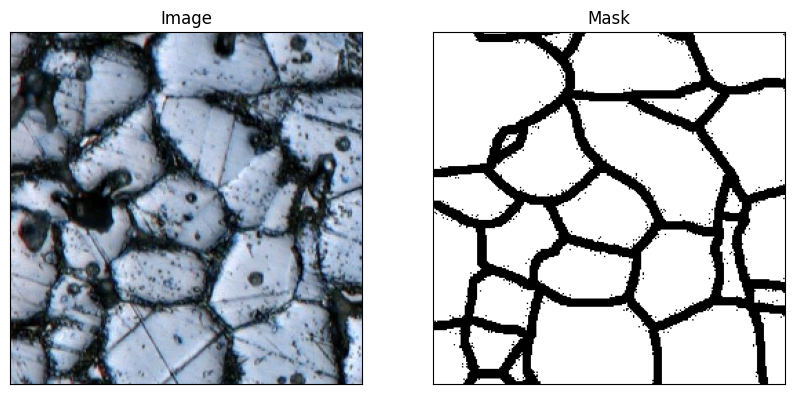

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import array


img_num = np.random.randint(0, images
.shape[0]-1)
example_image ,example_mask = dataset[img_num]

example_image = example_image.permute(1, 2, 0)
example_mask = example_mask.permute(1, 2, 0)


print(example_image.shape, example_mask.shape)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot the first image (assuming it's RGB) on the left
axes[0].imshow(example_image.numpy().astype(np.uint8))
axes[0].set_title("Image")

# Plot the second image (assuming it's grayscale) on the right
axes[1].imshow(example_mask.numpy().astype(np.uint8), cmap='gray')
axes[1].set_title("Mask")

# Hide axis ticks and labels
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# Display the images side by side
plt.show()


Get bounding boxes from masks. You can get here directly if you are working with coco style annotations where bounding boxes are captured in a JSON file.

In [ ]:
#Get bounding boxes from mask.
def get_bounding_box(ground_truth_map):
  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map[0] > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = ground_truth_map[0].shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox

In [ ]:
from torch.utils.data import Dataset

class SAMDataset(Dataset):
  """
  This class is used to create a dataset that serves input images and masks.
  It takes a dataset and a processor as input and overrides the __len__ and __getitem__ methods of the Dataset class.
  """
  def __init__(self, dataset, processor):
    self.dataset = dataset
    self.processor = processor

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, idx):
    item = self.dataset[idx]
    image = item[0]
    ground_truth_mask = np.array(item[1])

    # get bounding box prompt
    prompt = get_bounding_box(ground_truth_mask)

    # prepare image and prompt for the model
    inputs = self.processor(image, input_boxes=[[prompt]], return_tensors="pt")

    # remove batch dimension which the processor adds by default
    inputs = {k:v.squeeze(0) for k,v in inputs.items()}

    # add ground truth segmentation
    inputs["ground_truth_mask"] = ground_truth_mask

    return inputs

In [ ]:
# Initialize the processor
from transformers import SamProcessor
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

In [ ]:
from torch.utils.data import random_split

# Split the dataset into train and validation sets (80-10-10)
train_size = int(0.20 * len(dataset))
r = len(dataset) - train_size
val_size = int(0.5 * r)
test_size = int(0.5 * r)
train_dataset_, val_dataset_,test_dataset_ = random_split(dataset, [train_size, val_size,test_size])

In [ ]:
# Create an instance of the SAMDataset
train_dataset = SAMDataset(dataset=train_dataset_, processor=processor)
val_dataset = SAMDataset(dataset=val_dataset_, processor=processor)
test_dataset = SAMDataset(dataset=test_dataset_, processor=processor)


NameError: name 'SAMDataset' is not defined

In [ ]:
example = train_dataset[0]
for k,v in example.items():
  print(k,v.shape)


pixel_values torch.Size([3, 1024, 1024])
original_sizes torch.Size([2])
reshaped_input_sizes torch.Size([2])
input_boxes torch.Size([1, 4])
ground_truth_mask (1, 256, 256)


In [ ]:
# Create a DataLoader instance for the training dataset
from torch.utils.data import DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True, drop_last=False)
val_dataloader = DataLoader(val_dataset, batch_size=2, shuffle=True, drop_last=False)

In [ ]:
batch = next(iter(train_dataloader))
for k,v in batch.items():
  print(k,v.shape)

pixel_values torch.Size([2, 3, 1024, 1024])
original_sizes torch.Size([2, 2])
reshaped_input_sizes torch.Size([2, 2])
input_boxes torch.Size([2, 1, 4])
ground_truth_mask torch.Size([2, 1, 256, 256])


In [ ]:
batch["ground_truth_mask"].shape

torch.Size([2, 1, 256, 256])

In [ ]:
# Load the model
from transformers import SamModel
model = SamModel.from_pretrained("facebook/sam-vit-base")

# make sure we only compute gradients for mask decoder
for name, param in model.named_parameters():
  if name.startswith("vision_encoder") or name.startswith("prompt_encoder"):
    param.requires_grad_(False)

config.json:   0%|          | 0.00/6.57k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/375M [00:00<?, ?B/s]

In [ ]:
from torch.optim import Adam
import monai
# Initialize the optimizer and the loss function
optimizer = Adam(model.mask_decoder.parameters(), lr=1e-5, weight_decay=0)
#Try DiceFocalLoss, FocalLoss, DiceCELoss
seg_loss = monai.losses.DiceCELoss(sigmoid=True, squared_pred=True, reduction='mean')

In [ ]:
from tqdm import tqdm
from statistics import mean
import torch

# Early Stopping Setup
best_val_loss = float('inf')
patience = 5  # Number of epochs to wait after min has been hit. Change as per requirement.
patience_counter = 0

# Training loop
num_epochs = 20
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

for epoch in range(num_epochs):
    print(f'EPOCH: {epoch}')
    epoch_losses = []
    model.train()  # Ensure the model is in training mode

    for batch in tqdm(train_dataloader):
        # Forward pass
        outputs = model(pixel_values=batch["pixel_values"].to(device),
                        input_boxes=batch["input_boxes"].to(device),
                        multimask_output=False)

        # Compute loss
        predicted_masks = outputs.pred_masks.squeeze(1)
        ground_truth_masks = batch["ground_truth_mask"].float().to(device)
        loss = seg_loss(predicted_masks, ground_truth_masks)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()

        # Optimize
        optimizer.step()
        epoch_losses.append(loss.item())

    mean_train_loss = mean(epoch_losses)
    print(f'Mean training loss: {mean_train_loss}')

    # Validation phase
    model.eval()  # Set the model to evaluation mode
    val_losses = []
    with torch.no_grad():
        for batch in val_dataloader:
            # Forward pass
            outputs = model(pixel_values=batch["pixel_values"].to(device),
                            input_boxes=batch["input_boxes"].to(device),
                            multimask_output=False)

            # Compute loss
            predicted_masks = outputs.pred_masks.squeeze(1)
            ground_truth_masks = batch["ground_truth_mask"].float().to(device)
            loss = seg_loss(predicted_masks, ground_truth_masks)
            val_losses.append(loss.item())

    mean_val_loss = mean(val_losses)
    print(f'Mean validation loss: {mean_val_loss}')

    # Early Stopping Condition
    if mean_val_loss < best_val_loss:
        best_val_loss = mean_val_loss
        patience_counter = 0
        print("Best model saved with validation loss: {:.4f}".format(best_val_loss))
    else:
        patience_counter += 1
        print(f"No improvement in validation loss for {patience_counter} epochs.")
        if patience_counter >= patience:
            print("Stopping early due to no improvement in validation loss.")
            break


EPOCH: 0


100%|██████████| 12/12 [00:12<00:00,  1.06s/it]


Mean training loss: 0.5629014944036802
Mean validation loss: 0.5072895710666975
Best model saved with validation loss: 0.5073
EPOCH: 1


100%|██████████| 12/12 [00:11<00:00,  1.01it/s]


Mean training loss: 0.46928707261880237
Mean validation loss: 0.47009021913011867
Best model saved with validation loss: 0.4701
EPOCH: 2


100%|██████████| 12/12 [00:10<00:00,  1.10it/s]


Mean training loss: 0.44801100840171176
Mean validation loss: 0.45956124116977054
Best model saved with validation loss: 0.4596
EPOCH: 3


100%|██████████| 12/12 [00:10<00:00,  1.10it/s]


Mean training loss: 0.43795974055926007
Mean validation loss: 0.45416582624117535
Best model saved with validation loss: 0.4542
EPOCH: 4


100%|██████████| 12/12 [00:11<00:00,  1.00it/s]


Mean training loss: 0.43179881821076077
Mean validation loss: 0.45068162431319553
Best model saved with validation loss: 0.4507
EPOCH: 5


100%|██████████| 12/12 [00:11<00:00,  1.08it/s]


Mean training loss: 0.42727990945180255
Mean validation loss: 0.4476000393430392
Best model saved with validation loss: 0.4476
EPOCH: 6


100%|██████████| 12/12 [00:11<00:00,  1.07it/s]


Mean training loss: 0.42307380090157193
Mean validation loss: 0.44516975432634354
Best model saved with validation loss: 0.4452
EPOCH: 7


100%|██████████| 12/12 [00:11<00:00,  1.07it/s]


Mean training loss: 0.41969559093316394
Mean validation loss: 0.44299066935976344
Best model saved with validation loss: 0.4430
EPOCH: 8


100%|██████████| 12/12 [00:11<00:00,  1.07it/s]


Mean training loss: 0.4166750411192576
Mean validation loss: 0.4408782050013542
Best model saved with validation loss: 0.4409
EPOCH: 9


100%|██████████| 12/12 [00:11<00:00,  1.08it/s]


Mean training loss: 0.4139103516936302
Mean validation loss: 0.43883493542671204
Best model saved with validation loss: 0.4388
EPOCH: 10


100%|██████████| 12/12 [00:11<00:00,  1.07it/s]


Mean training loss: 0.41120123614867526
Mean validation loss: 0.4379291348159313
Best model saved with validation loss: 0.4379
EPOCH: 11


100%|██████████| 12/12 [00:11<00:00,  1.08it/s]


Mean training loss: 0.4089497352639834
Mean validation loss: 0.43499840671817463
Best model saved with validation loss: 0.4350
EPOCH: 12


100%|██████████| 12/12 [00:11<00:00,  1.07it/s]


Mean training loss: 0.4064721663792928
Mean validation loss: 0.43351658682028454
Best model saved with validation loss: 0.4335
EPOCH: 13


100%|██████████| 12/12 [00:11<00:00,  1.08it/s]


Mean training loss: 0.40425750364859897
Mean validation loss: 0.4321516764660676
Best model saved with validation loss: 0.4322
EPOCH: 14


100%|██████████| 12/12 [00:11<00:00,  1.07it/s]


Mean training loss: 0.4020593712727229
Mean validation loss: 0.43008190393447876
Best model saved with validation loss: 0.4301
EPOCH: 15


100%|██████████| 12/12 [00:11<00:00,  1.08it/s]


Mean training loss: 0.4000634228189786
Mean validation loss: 0.42877554272611934
Best model saved with validation loss: 0.4288
EPOCH: 16


100%|██████████| 12/12 [00:11<00:00,  1.07it/s]


Mean training loss: 0.3979245920976003
Mean validation loss: 0.42760736246903736
Best model saved with validation loss: 0.4276
EPOCH: 17


100%|██████████| 12/12 [00:11<00:00,  1.08it/s]


Mean training loss: 0.3961239531636238
Mean validation loss: 0.4264376126229763
Best model saved with validation loss: 0.4264
EPOCH: 18


100%|██████████| 12/12 [00:11<00:00,  1.07it/s]


Mean training loss: 0.39438461015621823
Mean validation loss: 0.42477887868881226
Best model saved with validation loss: 0.4248
EPOCH: 19


100%|██████████| 12/12 [00:11<00:00,  1.08it/s]


Mean training loss: 0.39255211999018985
Mean validation loss: 0.4242156284550826
Best model saved with validation loss: 0.4242


In [ ]:
# Save the model's state dictionary to a file
torch.save(model.state_dict(), "/content/drive/MyDrive/465 Project/SAM Checkpoints/SAM segmentation grain-1(10 epch 80-10-10 split).pth")

**Inference**

In [ ]:
from transformers import SamModel, SamConfig, SamProcessor
import torch

In [ ]:
# Load the model configuration
model_config = SamConfig.from_pretrained("facebook/sam-vit-base")
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

# Create an instance of the model architecture with the loaded configuration
my_grain_model = SamModel(config=model_config)
#Update the model by loading the weights from saved file.
my_grain_model.load_state_dict(torch.load("/content/drive/MyDrive/465 Project/SAM Checkpoints/SAM segmentation grain-1(10 epch 80-10-10 split).pth"))

In [ ]:
# set the device to cuda if available, otherwise use cpu
device = "cuda" if torch.cuda.is_available() else "cpu"
my_grain_model.to(device)

In [ ]:
import numpy as np
import random
import torch
import matplotlib.pyplot as plt

# let's take a random training example
idx = random.randint(0, len(test_dataset_)-1)

# load image
test_image = test_dataset_[idx][0]
test_mask = test_dataset_[idx][1]

# get box prompt based on ground truth segmentation map
ground_truth_mask = np.array(dataset[idx][1])
prompt = get_bounding_box(ground_truth_mask)

# prepare image + box prompt for the model
inputs = processor(test_image, input_boxes=[[prompt]], return_tensors="pt")

# Move the input tensor to the GPU if it's not already there
inputs = {k: v.to(device) for k, v in inputs.items()}

my_grain_model.eval()

# forward pass
with torch.no_grad():
    outputs = my_grain_model(**inputs, multimask_output=False)

# apply sigmoid
medsam_seg_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))
# convert soft mask to hard mask
medsam_seg_prob = medsam_seg_prob.cpu().numpy().squeeze()
medsam_seg = (medsam_seg_prob > 0.5).astype(np.uint8)


fig, axes = plt.subplots(1, 4, figsize=(15, 5))

# Plot the first image on the left
axes[0].imshow(test_image.permute(1, 2, 0).numpy().astype(np.uint8))
axes[0].set_title("Image")

axes[1].imshow(test_mask.permute(1, 2, 0).numpy().astype(np.uint8), cmap='gray')
axes[1].set_title("Ground Truth")

# Plot the second image on the right
axes[2].imshow(medsam_seg, cmap='gray')  # Assuming the second image is grayscale
axes[2].set_title("Mask")

# Plot the second image on the right
axes[3].imshow(medsam_seg_prob)  # Assuming the second image is grayscale
axes[3].set_title("Probability Map")

# Hide axis ticks and labels
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# Display the images side by side
plt.show()


NameError: name 'test_dataset_' is not defined

In [ ]:
!pip install -q torchmetrics

In [ ]:
test_dataloader = DataLoader(val_dataset,batch_size=2, shuffle=False, drop_last=False)

from torchmetrics.functional import dice

total_dice_score = 0.0
total_num_samples = 0

cnt = 0
for batch in tqdm(test_dataloader):
    cnt+=1
    with torch.no_grad():

        # forward pass
        outputs = my_grain_model(pixel_values=batch["pixel_values"].to(device),
                        input_boxes=batch["input_boxes"].to(device),
                        multimask_output=False)

        # compute loss
        predicted_masks = outputs.pred_masks.squeeze(1)
        ground_truth_masks = batch["ground_truth_mask"].float().to(device)

        for ind in range(len(predicted_masks)):
            pred_tensor = (predicted_masks[ind] > 0.5).float()
            gt_tensor = ground_truth_masks[ind].to(torch.int64)  # Convert mask tensor to integer tensor

            dice_score = dice(pred_tensor, gt_tensor)
            total_dice_score += dice_score.item()

total_num_samples = 2*cnt

average_dice_score = total_dice_score / total_num_samples

print(f"Training set: {TRAINING_SET}")
print(f"Total Number samples: {total_num_samples}")
print(f"Average Dice Score: {average_dice_score}")